<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/algorithm/linalg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 線形方程式の求解

In [186]:
%reset -f

### 直接法  

#### LU分解

LU分解のアルゴリズムの詳細は[ここ](https://risalc.info/src/LU-decomposition.html)を参照。
$A=PLU$を求める。

$P$は置換行列$P^T=P^{-1}$、$L$は対角成分1の下三角行列、$U$は上三角行列。

LU分解から部分ピボット選択付きガウスの消去法が可能。
$A\vec{x}=PLU\vec{x}=\vec{b}⇔LU\vec{x}=P^T\vec{b}$であるので
$P$が部分ピボット選択に対応。
$L\vec{y}=P^T\vec{b}, U\vec{x}=\vec{y}$として代入操作で解けば、
これは前進・後退代入に対応。

ランダムに生成した正方行列で検証。numpy の LU 分解の機能を使う。
（非正方行列は[疑似逆行列の計算法](https://www.momoyama-usagi.com/entry/math-linear-algebra-ap08)を適用したものとする。）

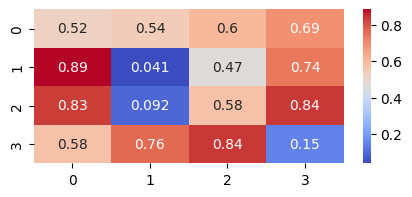

In [187]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 表示の精度を設定
np.set_printoptions(precision=3, suppress=False)
plt.rcParams['figure.figsize'] = (5, 2)

N = 4
A = np.random.rand(N, N)
sns.heatmap(A, annot=True, cmap='coolwarm')
plt.show()

P:


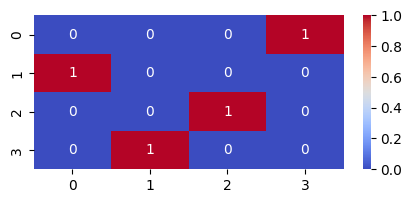

L:


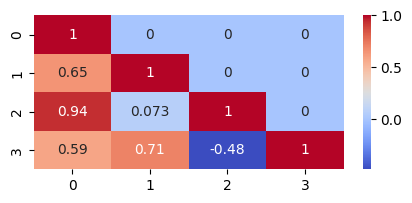

U:


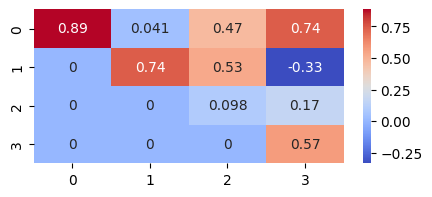

In [188]:
import scipy.linalg as linalg
P, L, U = linalg.lu(A)

print("P:")
sns.heatmap(P, annot=True, cmap='coolwarm')
plt.show()
print("L:")
sns.heatmap(L, annot=True, cmap='coolwarm')
plt.show()
print("U:")
sns.heatmap(U, annot=True, cmap='coolwarm')
plt.show()

検算

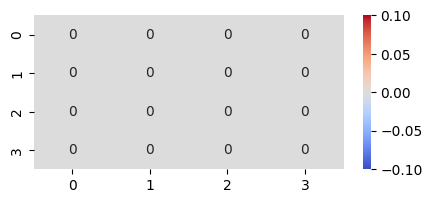

In [189]:
residuals = A - P @ L @ U
sns.heatmap(residuals, annot=True, cmap='coolwarm')
plt.show()

ここから$A\vec{x}=\vec{b}$を解くために$\vec{b}$を生成

In [190]:
b = np.random.rand(N)
print(f"{b=}")

b=array([0.95 , 0.418, 0.581, 0.522])


$L\vec{y}=P^T\vec{b}$ を解く。
前進代入は$y_i=b'_i-\sum_{j=0}^{i-1}l_{ij}y_j$。

In [191]:
def forward_substitute(P, L, b):
    y = np.zeros(N)
    for i in range(N):
        y[i] = (P.T @ b)[i] - L[i, :i] @ y[:i]
    return y

y = forward_substitute(P, L, b)
print(f"{y=}")

y=array([0.418, 0.25 , 0.17 , 0.61 ])


$U\vec{x}=\vec{y}$ を解く。
後退代入は$x_i=(y_i-\sum_{j=i+1}^nu_{ij}x_j)/u_{ii}$。

In [192]:
def backward_substitute(U, y):
    x = np.zeros(N)
    for i in range(N-1, -1, -1):
        x[i] = (y[i] - U[i, i+1:] @ x[i+1:]) / U[i, i]
    return x

x = backward_substitute(U, y)
print(f"{x=}")

x=array([-0.411,  0.882, -0.087,  1.063])


検算を実施

In [193]:
residuals = A @ x - b
print(residuals)

[-1.11e-16  0.00e+00 -1.11e-16  0.00e+00]


逆行列もLU分解から求まる。$AA^{-1}=I$なので$A\vec{x}_i=\vec{e}_i$を解けばいい。これは他の手法でも同じ。

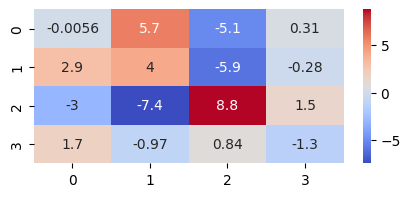

In [194]:
Ainv = np.zeros_like(A)
for i in range(N):
    e = np.zeros(N)
    e[i] = 1
    y = forward_substitute(P, L, e)
    x = backward_substitute(U, y)
    Ainv[:, i] = x

sns.heatmap(Ainv, annot=True, cmap='coolwarm')
plt.show()

検算

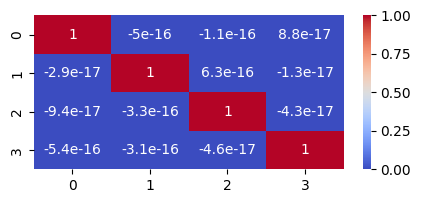

In [195]:
sns.heatmap(A @ Ainv, annot=True, cmap='coolwarm')
plt.show()

#### コレスキー分解法

解くべき連立一次方程式$A\vec{x}=\vec{b}$の係数行列$A$が非負定値ならコレスキー分解が可能なので、これを利用。

不定値なら$(A^TA)\vec{x}=A^T\vec{b}$を解く。$A^TA$は必ず対称で非負定値(特異値分解の部分を参照)。

### 間接法

間接法は反復更新で解に収束させることで解く。
共役勾配法なら2次形式の最適化問題に変形して適用。

## 特異値分解

In [159]:
%reset -f

### 右特異ベクトル

行列 $A$ に対して行列 $A^TA$ を考える。
明らかに $(A^TA)^T=A^TA$ なので対称行列。
[スペクトル定理](https://ja.wikipedia.org/wiki/%E3%82%B9%E3%83%9A%E3%82%AF%E3%83%88%E3%83%AB%E5%AE%9A%E7%90%86)より固有値は常に実数である。

また行列 $A$ の非負定値の条件は任意の $\vec{x}\neq\vec{0}$ に対して $\vec{x}^TA\vec{x}\geq0$。
よって任意の $A, \vec{x}\neq\vec{0}$ に対して $\vec{x}^T(A^TA)\vec{x}=||A\vec{x}||^2\geq0$。
これより固有値は常に非負である。そのため固有値の平方根も常に実数である。

これは $AA^T$ でも同様に成立。

実際に確かめるために乱数生成の行列でこれを計算。

<Axes: >

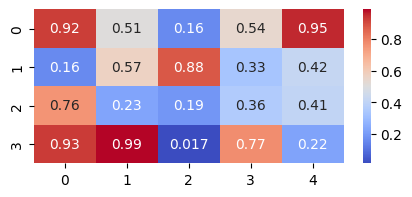

In [160]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 表示の精度を設定
np.set_printoptions(precision=3, suppress=False)
plt.rcParams['figure.figsize'] = (5, 2)

N, M = 4, 5
A = np.random.rand(N, M)
sns.heatmap(A, annot=True, cmap='coolwarm')

$A^TA$ は対称行列

<Axes: >

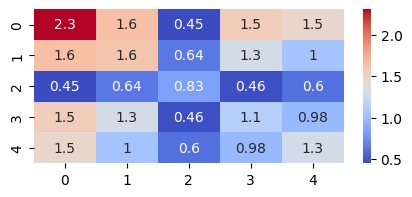

In [161]:
ATA = A.T @ A
sns.heatmap(ATA, annot=True, cmap='coolwarm')

固有値はすべて実数で非負（数値誤差に注意）

w_right=array([ 5.928e+00,  7.587e-01,  4.419e-01,  5.733e-02, -2.401e-16])


<Axes: >

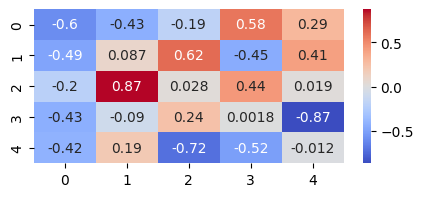

In [162]:
import numpy.linalg as la

w_right, V = la.eigh(ATA)
# 固有値が大きい順
w_right, V = w_right[::-1], V[:, ::-1]
print(f"{w_right=}")
sns.heatmap(V, annot=True, cmap='coolwarm')

固有ベクトルは$V$の各列が対応。
検算で $\vec{v}^T(A^TA)\vec{v}-w$ を計算。

<Axes: >

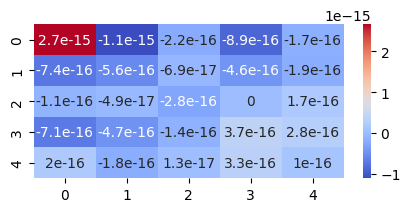

In [163]:
residuals = V.T @ ATA @ V - np.diag(w_right)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

$V$ 行列は直交行列(ユニタリー行列)で[右特異ベクトル](https://manabitimes.jp/math/1280#5)

<Axes: >

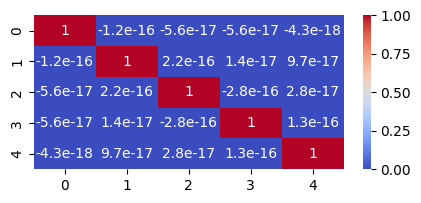

In [164]:
import seaborn as sns

# 検算。ユニタリなら単位行列に近くなる。
sns.heatmap(V.T @ V, annot=True, cmap='coolwarm')

### 左特異ベクトル

同様に $AA^T$ について計算し左特異ベクトル$U$を求める

w_left=array([5.928, 0.759, 0.442, 0.057])


<Axes: >

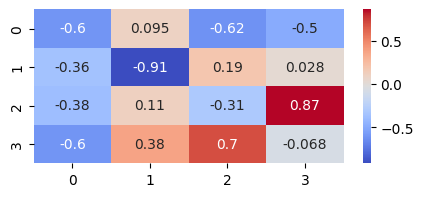

In [165]:
AAT = A @ A.T
w_left, U = la.eigh(AAT)
# 固有値が大きい順
w_left, U = w_left[::-1], U[:, ::-1]

print(f"{w_left=}")
sns.heatmap(U, annot=True, cmap='coolwarm')

左特異ベクトルを検算

<Axes: >

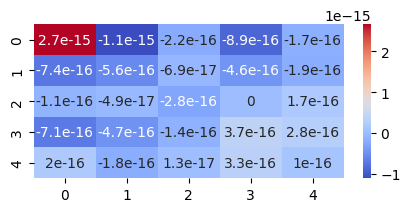

In [166]:
residuals = V.T @ ATA @ V - np.diag(w_right)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

<Axes: >

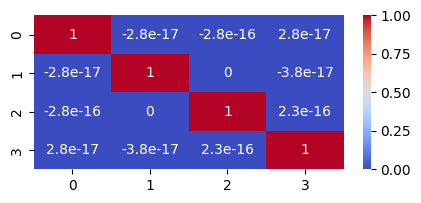

In [167]:
sns.heatmap(U.T @ U, annot=True, cmap='coolwarm')

### 特異値分解

数値誤差の対策。ほぼ0は0とする。

In [168]:
w_right = np.array([w if abs(w) > 1e-10 else 0 for w in w_right])
w_left = np.array([w if abs(w) > 1e-10 else 0 for w in w_left])
print(f"{w_right=}")
print(f"{w_left=}")

w_right=array([5.928, 0.759, 0.442, 0.057, 0.   ])
w_left=array([5.928, 0.759, 0.442, 0.057])


$A^TA, AA^T$ の固有値の平方根は特異値

In [169]:
sigma_right = np.sqrt(w_right)
sigma_left = np.sqrt(w_left)
print(f"{sigma_right=}")
print(f"{sigma_left=}")

sigma_right=array([2.435, 0.871, 0.665, 0.239, 0.   ])
sigma_left=array([2.435, 0.871, 0.665, 0.239])


特異値による行列 $\Sigma$ を作成

In [170]:
Sigma = np.zeros_like(A)
sigma = sigma_right if len(sigma_right) < len(sigma_left) else sigma_left
Sigma[:len(sigma), :len(sigma)] = np.diag(sigma)
print(f"{Sigma=}")

Sigma=array([[2.435, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.871, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.665, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.239, 0.   ]])


固有ベクトルには符号の不定性があるためそのままでは$A=U\Sigma V^T$を満たすとは限らない。

$\Sigma$の成分は非負なので$(AV)_i=\lambda_iU_i, \lambda_i\geq0$。
そこでこの[条件を満たすように符号の反転をする](
https://math.stackexchange.com/questions/4844816/discrepancies-in-custom-svd-implementation-compared-to-np-linalg-svd-sign-issu)。

<Axes: >

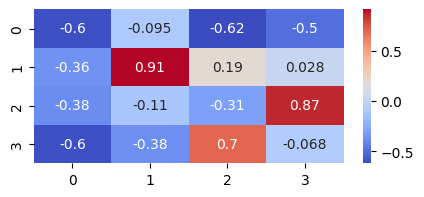

In [171]:
U = np.array([np.sign(np.dot(A @ V[:, idx], U[:, idx])) * U[:, idx]
    for idx in range(U.shape[1])]).T
sns.heatmap(U, annot=True, cmap='coolwarm')

[特異値分解](https://manabitimes.jp/math/1280#5) $A=U\Sigma V^T$ の検算。

<Axes: >

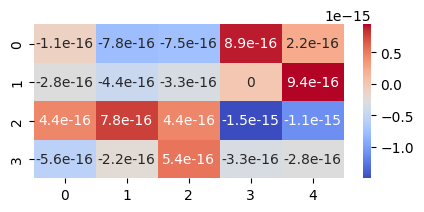

In [172]:
residuals = A - (U @ Sigma @ V.T)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

numpy の標準機能でも特異値分解。

In [173]:
U2, sigma2, V2h = la.svd(A)
print(sigma2)

[2.435 0.871 0.665 0.239]


特異ベクトルは符号の不定性があるため、対角化から求めた結果と一致するとは限らない。

sigma2-sigma=array([0.000e+00, 0.000e+00, 1.110e-16, 7.216e-16])


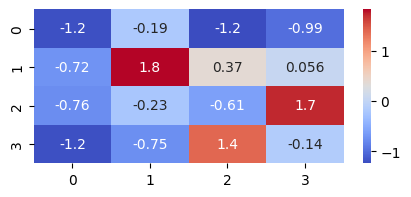

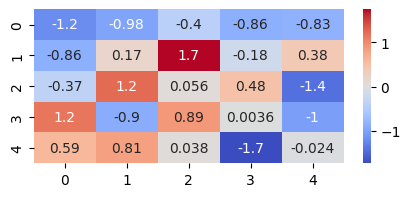

In [174]:
import matplotlib.pyplot as plt

print(f"{sigma2-sigma=}")
sns.heatmap(U-U2, annot=True, cmap='coolwarm')
plt.show()
sns.heatmap(V.T - V2h, annot=True, cmap='coolwarm')
plt.show()

特異分解$A=U\Sigma V^T$はきちんと満たす。

<Axes: >

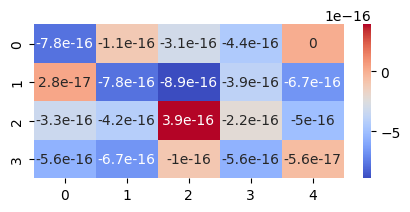

In [175]:
Sigma2 = np.zeros_like(A)
sigma2 = sigma_right if len(sigma_right) < len(sigma_left) else sigma_left
Sigma2[:len(sigma2), :len(sigma2)] = np.diag(sigma2)
residuals = A - (U2 @ Sigma2 @ V2h)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

## 固有値計算

アーベル・ルフィニの定理より5次以上の代数方程式には公式が存在しない。よって5x5行列の特性方程式は直接的に解けないため、反復法を使用する。